In [1]:
#IMPORT STATEMENTS
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import csv
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import copy
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score
import time

In [2]:
transform=transforms.Compose([
          transforms.Resize((224,224)),
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])


In [3]:
# Load datasets
train_set = ImageFolder(r'..\dataset\train', transform)
val_set = ImageFolder(r'..\dataset\val', transform)
test_set = ImageFolder(r'..\dataset\test', transform)

In [4]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [6]:
import timm
model = timm.create_model('inception_resnet_v2', pretrained=True)
model.eval()

d:\Projects\Rice Leaf Classification & Detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


InceptionResnetV2(
  (conv2d_1a): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2a): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2b): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size=(1, 

In [7]:
from torchsummary import summary 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

summary(model, input_size=(3,244,244))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 121, 121]             864
          Identity-2         [-1, 32, 121, 121]               0
              ReLU-3         [-1, 32, 121, 121]               0
    BatchNormAct2d-4         [-1, 32, 121, 121]              64
       ConvNormAct-5         [-1, 32, 121, 121]               0
            Conv2d-6         [-1, 32, 119, 119]           9,216
          Identity-7         [-1, 32, 119, 119]               0
              ReLU-8         [-1, 32, 119, 119]               0
    BatchNormAct2d-9         [-1, 32, 119, 119]              64
      ConvNormAct-10         [-1, 32, 119, 119]               0
           Conv2d-11         [-1, 64, 119, 119]          18,432
         Identity-12         [-1, 64, 119, 119]               0
             ReLU-13         [-1, 64, 119, 119]               0
   BatchNormAct2d-14         [-1, 

In [8]:
print("Train classes:", train_set.classes)  # Make sure it's 2
print("Class indices:", train_set.class_to_idx)


Train classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Class indices: {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}


In [24]:
# ✅ Let's check device placement before and after modification
print("=== BEFORE MODIFICATION ===")
print(f"Model device: {next(model.parameters()).device}")
print(f"Original classifier: {model.classif}")

# Get the input features from the original classifier
original_classif = model.classif
input_features = None

# Find the first Linear layer to get input features
for layer in original_classif.children():
    if isinstance(layer, nn.Linear):
        input_features = layer.in_features
        print(f"Found input features: {input_features}")
        break

# Replace the classifier layer for 3 classes
model.classif = nn.Sequential(
    nn.Linear(input_features, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 3)  # 3 classes: Bacterial leaf blight, Brown spot, Leaf smut
    # ❌ Removed Softmax - CrossEntropyLoss expects raw logits
)

print(f"\n=== AFTER MODIFICATION ===")
print(f"New classifier: {model.classif}")

# ✅ CRITICAL: Move the entire model to device AFTER modification
model = model.to(device)
print(f"Model device after moving: {next(model.parameters()).device}")

# Verify all layers are on the correct device
print(f"\n=== DEVICE CHECK ===")
for name, param in model.named_parameters():
    if 'classif' in name:
        print(f"{name}: {param.device}")
        
print(f"✅ Model ready for training!")

=== BEFORE MODIFICATION ===
Model device: cuda:0
Original classifier: Sequential(
  (0): Linear(in_features=1536, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=3, bias=True)
  (3): Softmax(dim=1)
)
Found input features: 1536

=== AFTER MODIFICATION ===
New classifier: Sequential(
  (0): Linear(in_features=1536, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=3, bias=True)
)
Model device after moving: cuda:0

=== DEVICE CHECK ===
classif.0.weight: cuda:0
classif.0.bias: cuda:0
classif.3.weight: cuda:0
classif.3.bias: cuda:0
✅ Model ready for training!


In [25]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [10]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
print(next(model.parameters()).device)


cuda:0


In [27]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [28]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, num_classes):
    since = time.time()
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = 0

    # Initialize CSV logging
    csv_filename = 'training_log.csv'
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train Loss', 'Train Acc', 'Train Precision', 'Train Recall', 'Train F1',
                         'Val Loss', 'Val Acc', 'Val Precision', 'Val Recall', 'Val F1'])

    # Initialize metrics
    train_precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    train_recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
    train_f1 = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

    val_precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    val_recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
    val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        all_train_preds = []
        all_train_labels = []

        # Training loop
        for inputs, labels in train_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_train_preds.append(predicted)
            all_train_labels.append(labels)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct / total
        all_train_preds = torch.cat(all_train_preds)
        all_train_labels = torch.cat(all_train_labels)

        # Compute Train Precision, Recall, F1
        train_precision_score = train_precision(all_train_preds, all_train_labels).item()
        train_recall_score = train_recall(all_train_preds, all_train_labels).item()
        train_f1_score = train_f1(all_train_preds, all_train_labels).item()

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}, "
              f"Training Accuracy: {train_accuracy:.2f}%, "
              f"Train Precision: {train_precision_score:.4f}, Train Recall: {train_recall_score:.4f}, Train F1: {train_f1_score:.4f}")

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)

                val_corrects += (predicted == labels).sum().item()
                all_val_preds.append(predicted)
                all_val_labels.append(labels)

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * val_corrects / len(val_loader.dataset)

        all_val_preds = torch.cat(all_val_preds)
        all_val_labels = torch.cat(all_val_labels)

        # Compute Validation Precision, Recall, F1
        val_precision_score = val_precision(all_val_preds, all_val_labels).item()
        val_recall_score = val_recall(all_val_preds, all_val_labels).item()
        val_f1_score = val_f1(all_val_preds, all_val_labels).item()

        print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}% | "
              f"Precision: {val_precision_score:.4f}, Recall: {val_recall_score:.4f}, F1: {val_f1_score:.4f}")

        # Append metrics to CSV
        with open(csv_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch+1, avg_train_loss, train_accuracy, train_precision_score, train_recall_score, train_f1_score,
                             avg_val_loss, val_accuracy, val_precision_score, val_recall_score, val_f1_score])

        # Save the best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1

    elapsed_time = time.time() - since
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    torch.save(best_model_wts, f"best_model_epoch_{best_epoch}.pth")
    print(f"\n✔️ Best model saved at epoch {best_epoch} with {best_val_acc:.2f}% accuracy")
    
    model.load_state_dict(best_model_wts)
    return model


In [29]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, device=device, num_classes=3)

Epoch [1/100], Training Loss: 0.0315, Training Accuracy: 42.71%, Train Precision: 0.4172, Train Recall: 0.4271, Train F1: 0.4199
Epoch [1/100], Val Loss: 0.4133, Val Acc: 75.00% | Precision: 0.8571, Recall: 0.7500, F1: 0.7091
Epoch [1/100], Val Loss: 0.4133, Val Acc: 75.00% | Precision: 0.8571, Recall: 0.7500, F1: 0.7091
Epoch [2/100], Training Loss: 0.0136, Training Accuracy: 87.50%, Train Precision: 0.8816, Train Recall: 0.8750, Train F1: 0.8760
Epoch [2/100], Training Loss: 0.0136, Training Accuracy: 87.50%, Train Precision: 0.8816, Train Recall: 0.8750, Train F1: 0.8760
Epoch [2/100], Val Loss: 4.4804, Val Acc: 58.33% | Precision: 0.6429, Recall: 0.5833, F1: 0.5786
Epoch [2/100], Val Loss: 4.4804, Val Acc: 58.33% | Precision: 0.6429, Recall: 0.5833, F1: 0.5786
Epoch [3/100], Training Loss: 0.0098, Training Accuracy: 89.58%, Train Precision: 0.9013, Train Recall: 0.8958, Train F1: 0.8947
Epoch [3/100], Training Loss: 0.0098, Training Accuracy: 89.58%, Train Precision: 0.9013, Train 

InceptionResnetV2(
  (conv2d_1a): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2a): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2b): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size=(1, 

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(device)

cuda


In [31]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    auc = roc_auc_score(y_true, y_probs, multi_class='ovr')

    return {
        "accuracy": report["accuracy"],
        "precision": np.mean([report[cls]["precision"] for cls in class_names]),
        "recall": np.mean([report[cls]["recall"] for cls in class_names]),
        "f1_score": np.mean([report[cls]["f1-score"] for cls in class_names]),
        "roc_auc": auc
    }


In [32]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ✅ Use a raw string or double backslashes to avoid escape character errors
test_dir = r"..\dataset\test"

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = test_dataset.classes
print("Classes:", class_names)


Classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


In [36]:

import torch
import torch.nn as nn
import timm
model = timm.create_model('inception_resnet_v2', pretrained=True)
model.eval()

# Freeze earlier layers
for param in model.parameters():
    param.requires_grad = False

# Replace FC layer
model.classif = nn.Sequential(
    nn.Linear(input_features, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 3)  # 3 classes: Bacterial leaf blight, Brown spot, Leaf smut
    # ❌ Removed Softmax - CrossEntropyLoss expects raw logits
)

# ✅ Model dict with only ResNett18
models_dict = {
    "model": model
}

model_paths = {
    "model": r"best_model_epoch_10.pth"
}

# ✅ Load weights and move to device
for name, model in models_dict.items():
    model.load_state_dict(torch.load(model_paths[name], map_location=device))
    model.to(device)
    model.eval()  # Important: Set model to eval mode
    print(f"[INFO] Loaded model: {name}")

C:\Users\altaf\AppData\Local\Temp\ipykernel_25788\1237427918.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_paths[name], map_loc

[INFO] Loaded model: model


In [37]:
results = []

for name, model in models_dict.items():
    print(f"Evaluating {name}...")
    metrics = evaluate_model(model, test_loader, class_names)
    metrics["model"] = name
    results.append(metrics)

df_results = pd.DataFrame(results)
df_results = df_results[["model", "accuracy", "precision", "recall", "f1_score", "roc_auc"]]

Evaluating model...


In [38]:
log_path = "model_evaluation_log.csv"
df_results.to_csv(log_path, index=False)
print(f"Saved evaluation results to: {log_path}")
df_results

Saved evaluation results to: model_evaluation_log.csv


,model,accuracy,precision,recall,f1_score,roc_auc
0,model,1.0,1.0,1.0,1.0,1.0


Gathering ROC data for model...


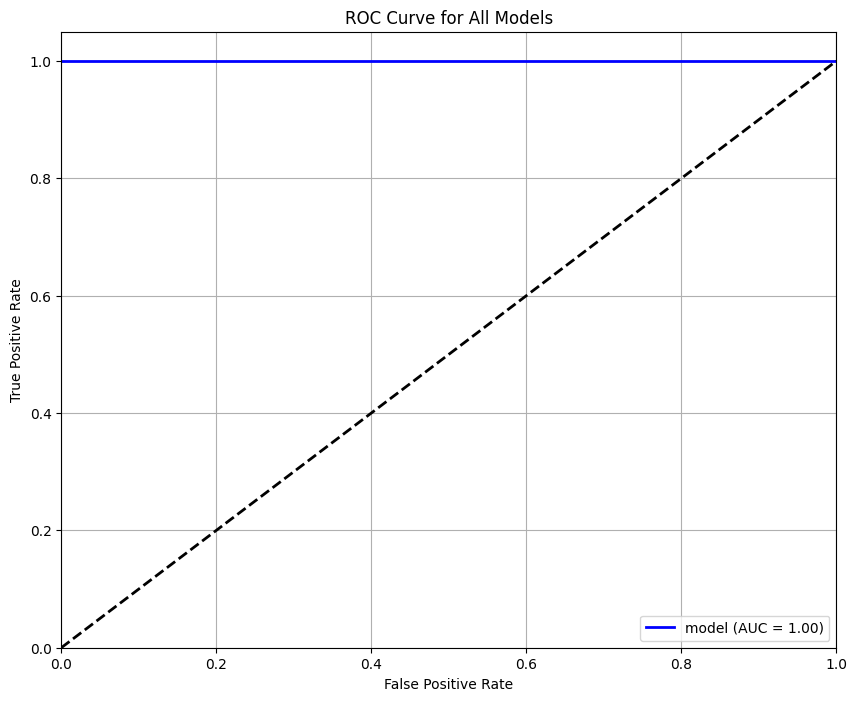

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


def get_predictions(model, dataloader, device):
    model.eval()
    y_true = []
    y_prob = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    return np.array(y_true), np.array(y_prob)

# Assuming you now collect this from evaluate_model per model
# Each model's true and predicted probabilities must be stored in a dictionary
roc_data = {}

for i, (name, model) in enumerate(models_dict.items()):
    print(f"Gathering ROC data for {name}...")
    y_true, y_prob = get_predictions(model, test_loader, device)
    roc_data[name] = (y_true, y_prob)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple']

for i, (name, (y_true, y_prob)) in enumerate(roc_data.items()):
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(len(class_names)):
        fpr[j], tpr[j], _ = roc_curve(y_true_bin[:, j], y_prob[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Macro-average AUC
    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
    mean_tpr /= len(class_names)

    macro_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, color=colors[i], lw=2,
             label=f"{name} (AUC = {macro_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_auc_comparison.png")
plt.show()


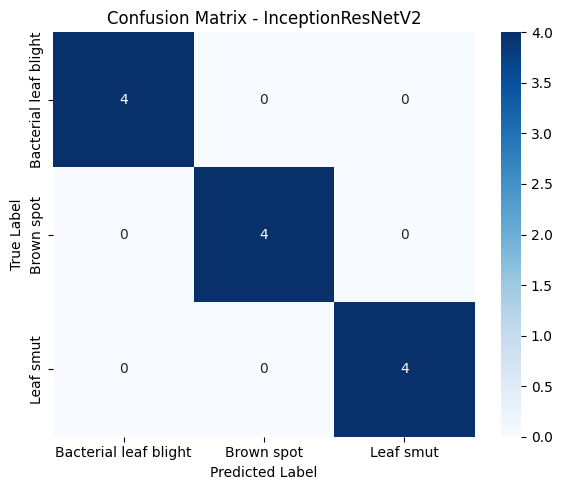

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Example class names
class_names = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

# Assuming y_true and y_prob are already defined for ResNet50
y_true, y_prob = roc_data["model"]  # Get predictions and probabilities
y_pred = np.argmax(y_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot 1x1 confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix - InceptionResNetV2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("inception_resnet_v2_confusion_matrix.png")
plt.show()
